# Chapter 0: Introduction

This chapter introduces the reader to a set of mathematical concepts that underly the perceptron.

## 0.4 Parallel Computation

The following is a simple implementation of Minsky's overview of parallel computation. 

For a function: $$\Psi(x)$$ 

we can compute a set of functions: $$\phi_1(x), \phi_2(x),...,\phi_n(x)$$

and then combine the results by means of a function for $n$ arguments: $$\Omega(\phi_1(x),\phi_2(x),...,\phi_n(x))$$ 

Minsky suggests that retstrictions must be placed on the definitions of $\Omega$ and the set of $\Phi$ functions such to avoid instances such as setting $\phi_1(x) = \Psi$ and letting $\phi_2(x),...,\phi_n(x) = 0$

To follow Minsky's example we will create a paralleizable function for determining if a the shape created by a series of points is convex.

#### Implementing the Grid

The first step is to determine the structure for the list of points that will make up a shape, and graph them to be sure we are properly representing our desired shape.

0: [0, 1]
i+1: [1, 1]
1: [1, 1]
i+1: [1, 0]
2: [1, 0]
i+1: [0, 0]
3: [0, 0]
i[o]: [0, 1]


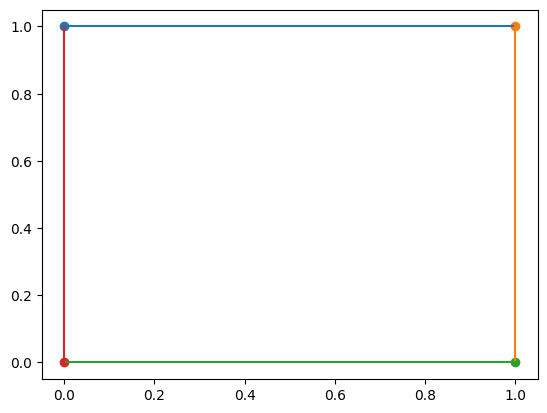

In [3]:
import matplotlib.pyplot as plt

convex_shape = [[0,1],[1,1],[1,0],[0,0]]
concave_shape = [[0,1],[1,1],[1,0],[0,0],[0.5,0.5]]

shape = convex_shape

for i in range(len(shape)):
    print(f'{i}: {shape[i]}')
    plt.scatter(shape[i][0], shape[i][1])
    if i + 1 < len(shape):
        plt.plot([shape[i][0], shape[i+1][0]], [shape[i][1], shape[i+1][1]])
        print(f'i+1: {shape[i+1]}')
    else:
        plt.plot([shape[i][0], shape[0][0]], [shape[i][1], shape[0][1]])
        print(f'i[o]: {shape[0]}')

plt.show()

### Testing Convexity of the Shape

Now that we have defined our polygon with points, lets create a function that can check if it is convex.

We know that a polygon is convex if every internal angle is less than $180^\circ$

We have defined our shape as consisting of ordered points $P_n$ points containing a 2D coordinate $(x_n, y_n)$ such that the points connect and wrap back around as follows: $$P_0 \rarr P_1, P_1 \rarr P_2,..., P_n \rarr P_0$$

For each triplet of points $A = P_i, B = P_{i+1}, and C = P_{i+2}$ we define two vectors: $$\vec{AB} = B - A = (x_2 - x_1, y_2 - y_1)$$ $$\vec{BC} = C - B = (x_3 - x_2, y_3 - y_2)$$

We can then compute the cross product of the vectors $\vec{AB}$ and $\vec{BC}$: 
$$\vec{AB} = (AB_x, AB_y)$$ 
$$\vec{BC} = (BC_x, BC_y)$$ 
$$ \vec{AB} \times \vec{BC} = AB_x \cdot BC_y - AB_y \cdot BC_x $$

For a set of computed cross products $Cross_n$ if all cross products are of an equal sign (or zero) we have determined the shape to be convex.

The following implementation checks if a shape is convex as described:

In [ ]:
import numpy as np

shape = concave_shape
signs = set()

for i in range(len(shape)):
    A = shape[i]
    
    if i + 1 < len(shape):
        B = shape[i+1]
        if i + 2 < len(shape):
            C = shape[i+2]
        else:
            C = shape[0]
    else:
        B = shape[0]
        C = shape[1]

    AB = [B[0] - A[0], B[1] - A[1]]
    BC = [C[0] - B[0], C[1] - B[1]]

    CR = np.cross(AB, BC)

    signs.add(np.float64(np.sign(CR)))

print(signs)
if len(signs) == 1:
    print("Convex")
else:
    print("Concave")


{np.float64(1.0), np.float64(-1.0)}
Concave


C:\Users\jmcke\AppData\Local\Temp\ipykernel_23868\4010885267.py:22: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  CR = np.cross(AB, BC)


#### Result: 

We can see that if there are multiple items in the set then the signs are not all equal. Conversely if the set length is equal to one, we have proven the shape to be convex.

### Paralleization 

In complex cases we may want to split up the process of computing the cross product over a set of computing threads to increase efficency. To this end, we must break down the mathematical process of proving convexity into a set of subprocesses that can be distributed, then recombined for the final result. Comparing the signs of cross products works nicely in this example because the operations are entirely independent. We just want to know if any of the results do not match, we don't necessarity care about *what* the result is. 
We can can represent the basis for this split computation as follows, based on Minsky's original formulas:

For our convex function: $$\Psi(x)$$ 

We can compute a set of functions for each subdivision of triplet point pairs: $$\phi_1(x), \phi_2(x),...,\phi_n(x)$$

and then combine the results by means of a function $\Omega$ that checks if all results match for $n$ arguments: $$\Omega(\phi_1(x),\phi_2(x),...,\phi_n(x))$$ 

##### Assignment

We abide by Minsky's restrictions for the definitions of $\Omega$ and the set of $\Phi$ functions by allocating the triplet pairs evenly amongst $k$ subprocesses using the following function:

Let $m$ equal the total number of triplet pairs of verticies, and $k$ equal the number of subprocesses:

$$q = \frac{m}{k}, \quad r = m, \mod k$$

Where $q$ is the number of triplets each subproceess is allocated, and $r$ is the remaining number of triples to distribute.

Each subprocess $S_i$ is then assinged:

$$
\text{Triplets}_i = 
\begin{cases}
q + 1 & \text{if } i \lt r \\
q & \text{if } i \ge r
\end{cases}
$$

##### Subproceeses

$$
\phi_i(x) = \text{sign}((P_{3i+1} - P_{3i}) \times (P_{3i+2} - P_{3i+1}))
$$

Where each $\phi_i$ evaluates the cross product of a specific triplet in the ordered point sequence. These $\phi_i$ functions are **independent** and can be computed in parallel.

The result of each $\phi_i(x)$ is an integer: either $-1$, $0$, or $1$, representing a right turn, colinearity, or a left turn, respectively.

We then define a final combination function $\Omega$:

$$
\Omega(\phi_1(x), \phi_2(x), ..., \phi_n(x)) =
\begin{cases}
1 & \text{if all } \phi_i(x) \text{ have the same non-zero sign} \\
0 & \text{otherwise}
\end{cases}
$$

This $\Omega$ function determines the convexity of the entire polygonal shape:  
- If the sign remains consistent across all triplets, the shape is convex.  
- If even one $\phi_i$ deviates in sign, or becomes zero (under a strict definition), the shape is not convex.

In this way, the evaluation of convexity is restructured into a form suitable for parallel execution:  
- **Each $\phi_i$ can be computed in a separate thread**  
- The combination step via $\Omega$ becomes a **reduction operation** (e.g., checking if all values are equal)

This mirrors Minsky's idea of parallelizing logical predicates across a structured input space and recombining them using logical or arithmetic operators — a foundational idea behind perceptron behavior and more broadly, parallel computation in intelligent systems.
